## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,,Unnamed: 25
0,BALTIMORE,,24 inch bins,,,,4/29/17,270.0,280.0,270,...,,,,,,,E,,,NaN
1,BALTIMORE,,24 inch bins,,,,5/6/17,270.0,280.0,270,...,,,,,,,E,,,NaN
2,BALTIMORE,,24 inch bins,HOWDEN TYPE,,,9/24/16,160.0,160.0,160,...,,,,,,,N,,,NaN
3,BALTIMORE,,24 inch bins,HOWDEN TYPE,,,9/24/16,160.0,160.0,160,...,,,,,,,N,,,NaN
4,BALTIMORE,,24 inch bins,HOWDEN TYPE,,,11/5/16,90.0,100.0,90,...,,,,,,,N,,,NaN


In [31]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


KeyError: 'Package'

A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

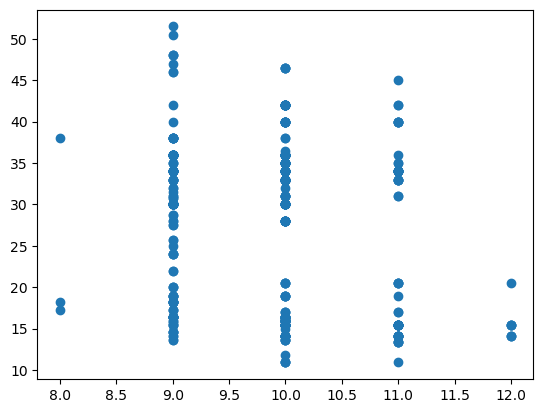

In [ ]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

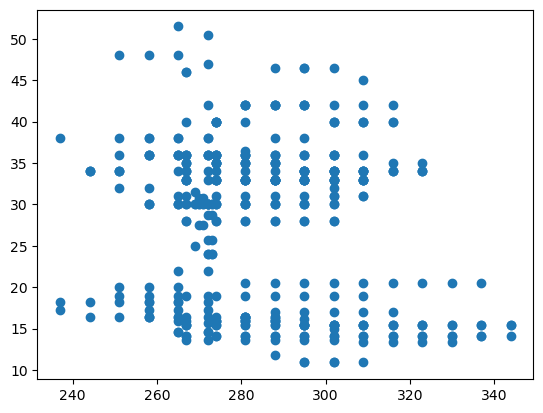

In [ ]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [ ]:
# Print the corelation in between month and price
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))

# Print the corelation in between Day of the year and price
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))


<Axes: xlabel='DayOfYear', ylabel='Price'>

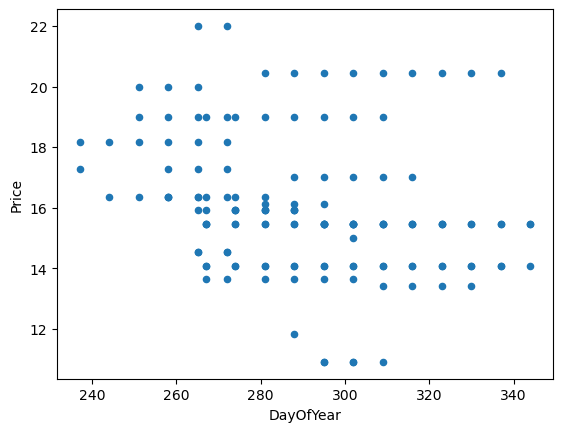

In [ ]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear', 'Price')

In [ ]:
# Print the corelation in between month and price
print(pie_pumpkins['Month'].corr(pie_pumpkins['Price']))

# Print the corelation in between Day of the year and price
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))

-0.23841413206125703
-0.2669192282197318


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Get the day of year and price in separate arrays
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1, 1)
y = pie_pumpkins['Price']

# Print the shape
X.shape      

(144, 1)

In [ ]:
# Split the data into training and testing data
X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Create a linear regression object
lin_reg = LinearRegression()

# Train the model using our training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Test the model using our test data
pred = lin_reg.predict(X_Test)
pred

array([16.21096253, 16.73652536, 16.08833121, 15.35254325, 15.96569988,
       16.73652536, 16.21096253, 16.36863138, 16.61389403, 15.84306855,
       15.84306855, 15.72043723, 16.21096253, 15.5978059 , 16.45622519,
       15.72043723, 15.5978059 , 16.08833121, 15.72043723, 16.36863138,
       16.85915669, 16.21096253, 15.22991192, 16.21096253, 15.84306855,
       16.45622519, 16.08833121, 15.84306855, 15.5978059 ])

In [ ]:
# Calculate the mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))

# Print the mean squared error in an easy to read format
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


In [ ]:
# Calculate the coefficient of determination
score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Model determination:  0.04460606335028361


In [ ]:
# Create a scatter plot using our test data
plt.scatter(X_Test, y_test)

# Add a line to the plot with predictions
plt.plot(X_Test,pred)


In [ ]:
# Print the slope and the intercept
print(f"y = {lin_reg.coef_[0]}x + {lin_reg.intercept_}")

y = -0.017518760953105x + 21.133734359909326


In [ ]:
# Print a prediction
lin_reg.predict([[256]])



array([16.64893156])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Build a polynomial regression pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

# Use the pipeline to build the model
pipeline.fit(X_train,y_train)

# Test the model with our test data
pred = pipeline.predict(X_Test)

# Calculate and print the mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')  

# Plot the results
plt.scatter(X_Test,y_test)
plt.plot(sorted(X_Test),pipeline.predict(sorted(X_Test)))

           


In [ ]:
# Calculate the coefficient of determination
score = pipeline.score(X_train, y_train)
print('Model determination: ', score)

In [ ]:
# Convert the variety into a categorical feature
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,False,False,False,True
71,False,False,False,True
72,False,False,False,True
73,False,False,False,True
74,False,False,False,True
...,...,...,...,...
1738,False,True,False,False
1739,False,True,False,False
1740,False,True,False,False
1741,False,True,False,False


In [ ]:
# Get the X value as a new data frame with the month column, along with
# variety converted into a categorical feature

X = pd.get_dummies(new_pumpkins['Variety']) \
    .join(new_pumpkins['Month'])\
        .join(pd.get_dummies(new_pumpkins['City'])) \
            .join(pd.get_dummies(new_pumpkins['Package']))

# Get the Y value as the price
y = new_pumpkins['Price']

print(X)
print(y)

In [32]:
# 1. make train test Split
X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 2. Create a linear regression object
lin_reg = LinearRegression()

# 3. Train the model using our training data
lin_reg.fit(X_train, y_train)

# 4. Test the model using our test data
pred = lin_reg.predict(X_Test)

# 5. Calculate the mean squared error and print in an easy to read format
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

# 6. Calculate the coefficient of determination and print
score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Mean error: 2.83 (10.5%)
Model determination:  0.9401047876434532


In [33]:
# 0. set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# 1. make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 2. setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# 3. predict results for test data
pred = pipeline.predict(X_test)

# 4. calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

# 5. Calculate the coefficient of determination and print
score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.26%)
Model determination:  0.9652399813840176
